In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

np.random.seed(0)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import logging

logging.basicConfig(level=logging.WARN)


<IPython.core.display.Javascript object>

In [3]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    Conv1D,
    SpatialDropout1D,
    LocallyConnected1D,
    Dense,
    Reshape,
    MaxPooling1D,
    BatchNormalization,
    Activation,
    LayerNormalization,
)

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow_addons.activations import mish
from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
from tensorflow_addons.layers import WeightNormalization

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder


from itertools import repeat
from concurrent.futures import ProcessPoolExecutor as PoolExecutor

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline


<IPython.core.display.Javascript object>

In [4]:
import tensorflow_addons as tfa

tfa.options.TF_ADDONS_PY_OPS = True

<IPython.core.display.Javascript object>

In [5]:
def word_to_np_array(word, cut_length):
    result = np.zeros(cut_length, dtype="uint8")
    for i, letter in enumerate(word[:cut_length]):
        result[i] = ord(letter)
    return result

<IPython.core.display.Javascript object>

In [6]:
def line_to_img(line, cut_length):
    result = np.zeros((line.shape[0], cut_length), dtype="uint8")
    for i in range(line.shape[0]):
        result[i] = word_to_np_array(line[i], cut_length)
    return result

<IPython.core.display.Javascript object>

In [7]:
def do_parallel_numpy(map_func, iter_params, constant_params=None):
    repeated_params = (
        [] if constant_params is None else list(map(repeat, constant_params))
    )
    results = None
    with PoolExecutor() as executor:
        results = np.stack(
            list(executor.map(map_func, *iter_params, *repeated_params)), axis=0
        )
    return results

<IPython.core.display.Javascript object>

In [8]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [9]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

In [10]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

dataset_name = "census-income"
out = Path(os.getcwd() + "/data/" + dataset_name + ".csv")
out_test = Path(os.getcwd() + "/data/" + dataset_name + "_test.csv")

download(url, out, force=False)
download(url_test, out_test, force=False)


File already exists.
File already exists.


<IPython.core.display.Javascript object>

In [11]:
cols = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "target",
]

<IPython.core.display.Javascript object>

In [104]:
train = pd.read_csv(out, names=cols)
test = pd.read_csv(out_test, names=cols, skiprows=2)
target = "target"

train[target] = train[target].str.strip()
# Test has . in label, let's clean it
test[target] = test[target].str.strip().str.strip(".")

<IPython.core.display.Javascript object>

In [105]:
target_encoder = LabelEncoder()

<IPython.core.display.Javascript object>

In [106]:
train[target] = target_encoder.fit_transform(train[target].values.reshape(-1))
test[target] = target_encoder.transform(test[target].values.reshape(-1))

<IPython.core.display.Javascript object>

In [107]:
used_columns = list(set(train.columns.tolist()) - set([target]) - set(["Set"]))
used_columns

['fnlwgt',
 'marital-status',
 'race',
 'education-num',
 'hours-per-week',
 'capital-loss',
 'native-country',
 'relationship',
 'workclass',
 'education',
 'sex',
 'occupation',
 'capital-gain',
 'age']

<IPython.core.display.Javascript object>

In [108]:
train["Set"] = np.random.choice(
    ["train", "valid"], p=[0.8, 0.2], size=(train.shape[0],)
)

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index

X_train = np.char.strip(train[used_columns].values[train_indices].astype("str"))
X_valid = np.char.strip(train[used_columns].values[valid_indices].astype("str"))

y_train = train[target].values[train_indices]
y_valid = train[target].values[valid_indices]

# Test here should be ignored for training, only purpose is benching with paper values
X_test = np.char.strip(test[used_columns].values.astype("str"))
y_test = test[target].values

del train, test, train_indices, valid_indices

<IPython.core.display.Javascript object>

In [109]:
X_train.shape

(26108, 14)

<IPython.core.display.Javascript object>

In [18]:
INPUT_DIM = X_train.shape[1]
NB_CHANNELS = np.vectorize(len)(X_train).max()
NB_CHANNELS

26

<IPython.core.display.Javascript object>

In [19]:
line_to_img(X_train[0], 27).shape

(14, 27)

<IPython.core.display.Javascript object>

In [110]:
X_train_preproc = do_parallel_numpy(line_to_img, [X_train], [NB_CHANNELS])
X_valid_preproc = do_parallel_numpy(line_to_img, [X_valid], [NB_CHANNELS])
X_test_preproc = do_parallel_numpy(line_to_img, [X_test], [NB_CHANNELS])

<IPython.core.display.Javascript object>

Y_train_preproc = to_categorical(y_train)
Y_valid_preproc = to_categorical(y_valid)
Y_test_preproc = to_categorical(y_test)

In [26]:
def build_model(input_dim, nb_channels, conv_dim=[], lconv_dim=[]):
    activation = mish
    optimizer = Lookahead(RectifiedAdam(1e-3), sync_period=6, slow_step_size=0.5)

    input_layer = Input(shape=(input_dim, nb_channels), name="input")
    x_layer = input_layer
    for i, conv_layer in enumerate(conv_dim):
        name = f"block_conv_{i}_"
        x_layer = Conv1D(
            filters=conv_layer,
            padding="valid",
            kernel_size=1,
            strides=1,
            name=name + "conv",
            use_bias=False,
            activation=None,
        )(x_layer)
        x_layer = BatchNormalization(name=name + "nb")(x_layer)
        x_layer = Activation(activation, name=name + "activation")(x_layer)

    for i, lconv_layer in enumerate(lconv_dim):
        name = f"block_lconv_{i}_"
        x_layer = LocallyConnected1D(
            filters=lconv_layer,
            padding="valid",
            kernel_size=1,
            strides=1,
            name=name + "lconv",
            use_bias=False,
            activation=None,
        )(x_layer)
        x_layer = BatchNormalization(name=name + "nb")(x_layer)
        x_layer = Activation(activation, name=name + "activation")(x_layer)

    nb_filters = lconv_dim[-1] if len(lconv_dim) > 0 else conv_dim[-1]
    x_layer = Reshape((input_dim * nb_filters,), name="reshape")(x_layer)
    x_layer = Dense(1, activation="sigmoid", name="output")(x_layer)

    model = Model(inputs=[input_layer], outputs=[x_layer], name="first_model")
    model.compile(loss="binary_crossentropy", optimizer=optimizer)

    return model

<IPython.core.display.Javascript object>

In [27]:
model = build_model(INPUT_DIM, NB_CHANNELS, conv_dim=[64], lconv_dim=[128, 64, 32])

<IPython.core.display.Javascript object>

In [28]:
model.summary()

Model: "first_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 14, 26)]          0         
_________________________________________________________________
block_conv_0_conv (Conv1D)   (None, 14, 64)            1664      
_________________________________________________________________
block_conv_0_nb (BatchNormal (None, 14, 64)            256       
_________________________________________________________________
block_conv_0_activation (Act (None, 14, 64)            0         
_________________________________________________________________
block_lconv_0_lconv (Locally (None, 14, 128)           114688    
_________________________________________________________________
block_lconv_0_nb (BatchNorma (None, 14, 128)           512       
_________________________________________________________________
block_lconv_0_activation (Ac (None, 14, 128)           

<IPython.core.display.Javascript object>

In [29]:
y_train.shape

(26072,)

<IPython.core.display.Javascript object>

In [30]:
%%time
history = model.fit(
    X_train_preproc,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=1024,
    validation_data=(X_valid_preproc, y_valid.reshape(-1, 1),),
    verbose=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=100, verbose=1)],
)

Epoch 1/2000


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


26/26 [==============================] - 6s 225ms/step - loss: 0.4962 - val_loss: 0.6910
Epoch 2/2000
26/26 [==============================] - 5s 201ms/step - loss: 0.3726 - val_loss: 0.6915
Epoch 3/2000
26/26 [==============================] - 5s 196ms/step - loss: 0.3486 - val_loss: 0.6933
Epoch 4/2000
26/26 [==============================] - 5s 200ms/step - loss: 0.3396 - val_loss: 0.6946
Epoch 5/2000
26/26 [==============================] - 5s 209ms/step - loss: 0.3344 - val_loss: 0.6932
Epoch 6/2000
26/26 [==============================] - 5s 207ms/step - loss: 0.3322 - val_loss: 0.6915
Epoch 7/2000
26/26 [==============================] - 5s 203ms/step - loss: 0.3315 - val_loss: 0.6775
Epoch 8/2000
26/26 [==============================] - 5s 196ms/step - loss: 0.3351 - val_loss: 0.6640
Epoch 9/2000
26/26 [==============================] - 5s 206ms/step - loss: 0.3300 - val_loss: 0.6425
Epoch 10/2000
26/26 [==============================] - 5s 207ms/step - loss: 0.3265 - val_loss:

Epoch 81/2000
26/26 [==============================] - 5s 199ms/step - loss: 0.2911 - val_loss: 0.2957
Epoch 82/2000
26/26 [==============================] - 6s 216ms/step - loss: 0.2911 - val_loss: 0.2906
Epoch 83/2000
26/26 [==============================] - 5s 206ms/step - loss: 0.2909 - val_loss: 0.3050
Epoch 84/2000
26/26 [==============================] - 5s 204ms/step - loss: 0.2897 - val_loss: 0.2958
Epoch 85/2000
26/26 [==============================] - 5s 197ms/step - loss: 0.2901 - val_loss: 0.2930
Epoch 86/2000
26/26 [==============================] - 6s 222ms/step - loss: 0.2903 - val_loss: 0.3056
Epoch 87/2000
26/26 [==============================] - 5s 205ms/step - loss: 0.2905 - val_loss: 0.2963
Epoch 88/2000
26/26 [==============================] - 5s 203ms/step - loss: 0.2894 - val_loss: 0.2962
Epoch 89/2000
26/26 [==============================] - 5s 203ms/step - loss: 0.2886 - val_loss: 0.3103
Epoch 90/2000
26/26 [==============================] - 5s 205ms/step - lo

Epoch 160/2000
26/26 [==============================] - 5s 199ms/step - loss: 0.2813 - val_loss: 0.2891
Epoch 161/2000
26/26 [==============================] - 5s 205ms/step - loss: 0.2817 - val_loss: 0.2881
Epoch 162/2000
26/26 [==============================] - 6s 234ms/step - loss: 0.2812 - val_loss: 0.2884
Epoch 163/2000
26/26 [==============================] - 6s 234ms/step - loss: 0.2798 - val_loss: 0.2823
Epoch 164/2000
26/26 [==============================] - 6s 223ms/step - loss: 0.2824 - val_loss: 0.2958
Epoch 165/2000
26/26 [==============================] - 5s 201ms/step - loss: 0.2837 - val_loss: 0.2855
Epoch 166/2000
26/26 [==============================] - 5s 197ms/step - loss: 0.2813 - val_loss: 0.2918
Epoch 167/2000
26/26 [==============================] - 5s 198ms/step - loss: 0.2818 - val_loss: 0.2927
Epoch 168/2000
26/26 [==============================] - 5s 207ms/step - loss: 0.2809 - val_loss: 0.2870
Epoch 169/2000
26/26 [==============================] - 5s 207ms

Epoch 239/2000
26/26 [==============================] - 6s 212ms/step - loss: 0.2756 - val_loss: 0.2786
Epoch 240/2000
26/26 [==============================] - 5s 202ms/step - loss: 0.2755 - val_loss: 0.2790
Epoch 241/2000
26/26 [==============================] - 5s 201ms/step - loss: 0.2771 - val_loss: 0.3154
Epoch 242/2000
26/26 [==============================] - 5s 205ms/step - loss: 0.2765 - val_loss: 0.2797
Epoch 243/2000
26/26 [==============================] - 6s 233ms/step - loss: 0.2758 - val_loss: 0.2771
Epoch 244/2000
26/26 [==============================] - 6s 225ms/step - loss: 0.2747 - val_loss: 0.2814
Epoch 245/2000
26/26 [==============================] - 5s 206ms/step - loss: 0.2753 - val_loss: 0.2787
Epoch 246/2000
26/26 [==============================] - 5s 211ms/step - loss: 0.2757 - val_loss: 0.2802
Epoch 247/2000
26/26 [==============================] - 5s 200ms/step - loss: 0.2758 - val_loss: 0.2777
Epoch 248/2000
26/26 [==============================] - 5s 200ms

Epoch 318/2000
26/26 [==============================] - 5s 189ms/step - loss: 0.2722 - val_loss: 0.2798
Epoch 319/2000
26/26 [==============================] - 5s 193ms/step - loss: 0.2726 - val_loss: 0.2755
Epoch 320/2000
26/26 [==============================] - 5s 196ms/step - loss: 0.2736 - val_loss: 0.2862
Epoch 321/2000
26/26 [==============================] - 5s 208ms/step - loss: 0.2728 - val_loss: 0.2831
Epoch 322/2000
26/26 [==============================] - 6s 229ms/step - loss: 0.2709 - val_loss: 0.2939
Epoch 323/2000
26/26 [==============================] - 5s 211ms/step - loss: 0.2747 - val_loss: 0.2765
Epoch 324/2000
26/26 [==============================] - 6s 215ms/step - loss: 0.2735 - val_loss: 0.2783
Epoch 325/2000
26/26 [==============================] - 6s 244ms/step - loss: 0.2759 - val_loss: 0.2788
Epoch 326/2000
26/26 [==============================] - 6s 213ms/step - loss: 0.2714 - val_loss: 0.2766
Epoch 327/2000
26/26 [==============================] - 6s 213ms

<IPython.core.display.Javascript object>

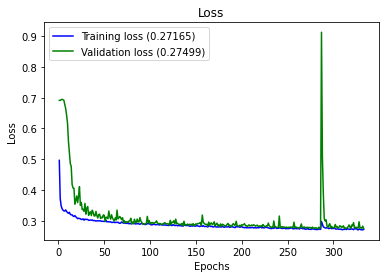

<IPython.core.display.Javascript object>

In [32]:
plot_history(history)

In [114]:
model_auc = roc_auc_score(
    y_true=y_valid, y_score=model.predict(X_valid_preproc).reshape(-1),
)
model_auc

0.9347420166297309

<IPython.core.display.Javascript object>

In [115]:
model_auc = roc_auc_score(
    y_true=y_test, y_score=model.predict(X_test_preproc).reshape(-1),
)
model_auc

0.9262939626480025

<IPython.core.display.Javascript object>

In [ ]:
# valid 0.9282381974389771 test 0.9262939626480025 conv_dim=[64], lconv_dim=[128, 64, 32] patience 50

In [79]:
SAMPLE_NB = 1000

<IPython.core.display.Javascript object>

In [80]:
sample = X_valid_preproc[:SAMPLE]

<IPython.core.display.Javascript object>

In [81]:
model_pred = model.predict(sample)
model_pred.shape

(1000, 1)

<IPython.core.display.Javascript object>

In [82]:
new_model = Model(inputs=[model.input], outputs=[model.output, model.layers[-3].output])

<IPython.core.display.Javascript object>

In [83]:
new_model_pred, feature_inter = new_model.predict(sample)

<IPython.core.display.Javascript object>

In [84]:
assert np.all(model_pred == new_model_pred)

<IPython.core.display.Javascript object>

In [85]:
feature_inter.shape

(1000, 14, 32)

<IPython.core.display.Javascript object>

In [89]:
for idx in range(sample.shape[1]):
    one_col = np.zeros(sample.shape)
    one_col[:, idx] = sample[:, idx]
    _, feature_inter_one_col = new_model.predict(one_col)
    assert np.all(feature_inter_one_col[:, idx, :] == feature_inter[:, idx, :])
    assert np.sum(feature_inter_one_col - feature_inter) > 1

<IPython.core.display.Javascript object>

In [90]:
idx = 0
one_col = np.zeros(sample.shape)
one_col[:, idx] = sample[:, idx]
_, feature_inter_one_col = new_model.predict(one_col)
assert np.all(feature_inter_one_col[:, idx, :] == feature_inter[:, idx, :])
assert np.sum(feature_inter_one_col - feature_inter) > 1

<IPython.core.display.Javascript object>

In [92]:
feature_inter_one_col[:, 0, :].shape

(1000, 32)

<IPython.core.display.Javascript object>

In [94]:
new_model.layers[-1]

<IPython.core.display.Javascript object>

In [102]:
model.get_weights()[-2].shape

(448, 1)

<IPython.core.display.Javascript object>

In [123]:
new_model = Model(inputs=[model.input], outputs=[model.output, model.layers[-2].output])

<IPython.core.display.Javascript object>

In [124]:
%%time
_, new_train_logistic = new_model.predict(X_train_preproc)
_, new_valid_logistic = new_model.predict(X_valid_preproc)
_, new_test_logistic = new_model.predict(X_test_preproc)

CPU times: user 12.4 s, sys: 9.54 s, total: 21.9 s
Wall time: 6.14 s


<IPython.core.display.Javascript object>

In [136]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

<IPython.core.display.Javascript object>

In [126]:
lreg = LogisticRegression(max_iter=200, n_jobs=-1)

<IPython.core.display.Javascript object>

In [127]:
new_train_logistic.shape

(26108, 448)

<IPython.core.display.Javascript object>

In [129]:
lreg.fit(new_train_logistic, y_train.reshape(-1))

LogisticRegression(max_iter=200, n_jobs=-1)

<IPython.core.display.Javascript object>

In [134]:
roc_auc_score(
    y_true=y_valid, y_score=lreg.predict_proba(new_valid_logistic)[:, 1],
)

0.9331454088086971

<IPython.core.display.Javascript object>

In [135]:
roc_auc_score(
    y_true=y_test, y_score=lreg.predict_proba(new_test_logistic)[:, 1],
)

0.9264309103810188

<IPython.core.display.Javascript object>

In [141]:
lreg_cv = LogisticRegressionCV(Cs=20, max_iter=2000, n_jobs=-1, cv=5, random_state=0)

<IPython.core.display.Javascript object>

In [142]:
lreg_cv.fit(new_train_logistic, y_train.reshape(-1))

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
roc_auc_score(
    y_true=y_valid, y_score=lreg_cv.predict_proba(new_valid_logistic)[:, 1],
)

In [ ]:
roc_auc_score(
    y_true=y_test, y_score=lreg_cv.predict_proba(new_test_logistic)[:, 1],
)